# Dichiaro Moduli utili e definizioni interessanti

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [2]:
def trova_massimi(time, voltage, prominence):
    # Trova i massimi locali con una soglia di prominenza per evitare falsi massimi
    peaks, _ = find_peaks(voltage, prominence=prominence)  # Soglia regolabile
    time_peaks = time[peaks]
    voltage_peaks = voltage[peaks]
    return time_peaks, voltage_peaks

In [3]:
def trova_minimi(time, voltage, prominence):
    # Trova i minimi locali con una soglia di prominenza per evitare falsi minimi
    troughs, _ = find_peaks(-voltage, prominence=prominence)  # Soglia regolabile
    time_troughs = time[troughs]
    voltage_troughs = voltage[troughs]
    return time_troughs, voltage_troughs

In [4]:
def Errore_R(R):

    return R*0.15/100 + 0.6
        

In [5]:
def Errore_C(C):

    return C*0.1

In [6]:
def Errore_tau(Tau, incertezza_C, incertezza_R):

    incertezza_Tau = np.sqrt(incertezza_C**2 + incertezza_R**2)
    return Tau*incertezza_Tau 

In [7]:
def Tau_with_c(x, A, tau, C):

    return (A * np.exp(-x/tau) + C) 

In [8]:
def De_Tau_with_c(x, A, tau, C):

    return (-A/tau) * np.exp(-x/tau)

In [9]:
def R_Parassita(Tau_r, C, R):

    return ((C/Tau_r) - 1/R)**(-1)

In [10]:
def Errore_R_Parassita(incertezza_Tau_r, incertezza_C, Err_R, C, R , Tau_r):

    R_eq = Tau_r/C
    Errore_R = Err_R/(R**2)
    Err_R_eq = (np.sqrt(incertezza_Tau_r**2 + incertezza_C**2))*(R_eq)
    Err_R_p = np.sqrt((Err_R_eq/(R_eq)**2)**2 + Errore_R**2)
    return Err_R_p

In [11]:
def Cof_R(x , w0 , C ):

    return (1/np.sqrt((1 + (x /w0)**2 ))) + C

In [12]:
def Errore_W_0(tau, err_tau):

    return 1/(2*np.pi) * 1/(tau**2)*err_tau

# Circuito RC con R pari a 573Ohm e C pari a 2.2 e-3 F

In [13]:
C_1 = 2.2e-3
C_2 = 1e-3
C_3 = 470e-6

R_1 = 573
R_2 = 215
R_3 = 1397

Tau_Ideale = np.array([C_1 * R_1, C_1 * R_2, C_1 * R_3, C_2 * R_2, C_3 * R_2])
Err_Tau_Ideale = []
Tau_Reale = []
Err_Tau_Reale = []

In [14]:
file_name = "Dente%2%R573.xlsx"
df = pd.read_excel(file_name)
#print(df)
Col_1 = "Time"
Col_2 = "Vc"
Col_3 = "Vg"
t = df[Col_1].to_numpy()
Vc = df[Col_2].to_numpy()
Vg = df[Col_3].to_numpy()

tau_i = C_1 * R_1 

#Calcolo Errori di C R e Tau

Err_R_1 = Errore_R(R_1)
Err_C_1 = Errore_C(C_1)
inc_R_1 = Err_R_1/R_1
inc_C_1 = Err_C_1/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C_1, inc_R_1)



i = 0
k = 0

Maxs, _ = find_peaks(Vc, prominence= 1)
Mins, _ = find_peaks(-Vc, prominence= 1)
dt_1 = t[Mins[i]:Maxs[k]:1]
dvc_1 = Vc[Mins[i]:Maxs[k]:1]
Error_Vg = 0.001

delta = dt_1 - t[Mins[i]]

popt, pcov = curve_fit(Tau_with_c, delta, dvc_1, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt



Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

y_fit = Tau_with_c(delta, A_fit, Tau_fit, C_fit)
y_dati = dvc_1

sigma_x = 0.005**2
sigma = y_fit - y_dati
err_y = np.sqrt(De_Tau_with_c(delta, A_fit, Tau_fit, C_fit)**2 + sigma_x) * 3

Err_Tau_r = np.sqrt(Disc_Tau) * 3



y_0 = np.zeros(len(delta))
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
index = [r'$\tau_{Reale}$',r'$\tau_{Ideale}$']

Tau_Reale.append(Tau_fit)
Err_Tau_Ideale.append(Err_Tau_i)
Err_Tau_Reale.append(Err_Tau_r)

Il Tau reale vale: 1.4814592085401823 +/- 0.00014901847588386544

Il Tau ideale vale: 1.2606000000000002 +/- 0.12610088611429346


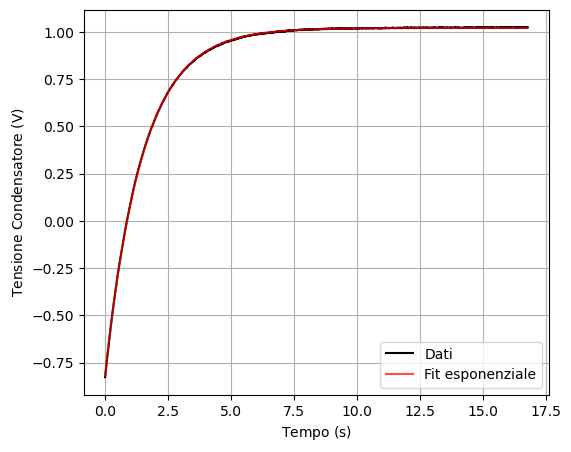

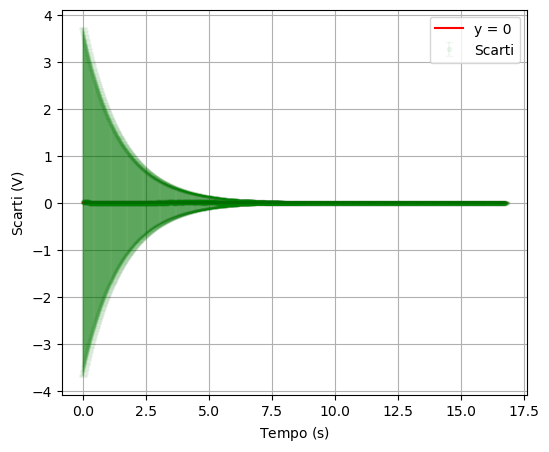

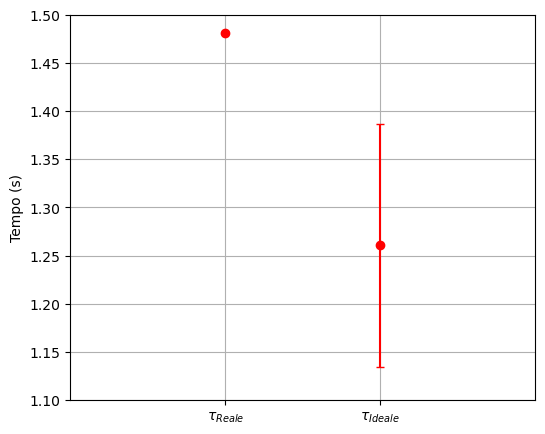

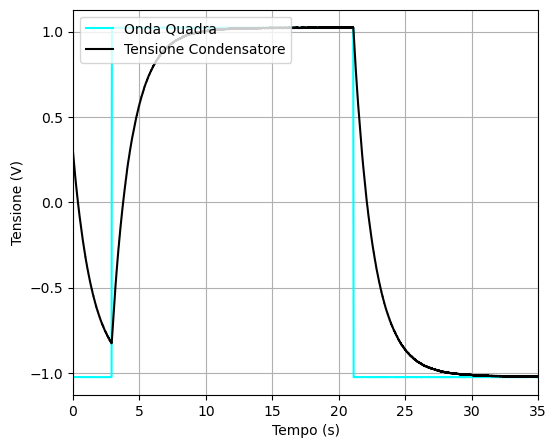

In [15]:
fig , ax = plt.subplots(figsize = (6,5))

ax.plot(delta, dvc_1, color = 'black', label = "Dati")
ax.plot(delta, y_fit, color= 'r', label= "Fit esponenziale", alpha = 0.7)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Tensione Condensatore (V)}$')
ax.grid(True)
fig.savefig("Grafico e fit(1).png", dpi = 300, bbox_inches = 'tight')
ax.legend()

fig ,ax =plt.subplots(figsize = (6,5))

ax.errorbar(delta, sigma, yerr = err_y, fmt = '.' , color = 'g', label = "Scarti", alpha = 0.05, capsize = 3 )
ax.plot(delta, y_0, color = 'r', label = "y = 0")
#plt.ylim(-0.01,0.02)
#plt.xlim(0 , 0.1)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Scarti (V)}$')
ax.legend()
plt.grid(True)
fig.savefig("Grafico Scarti(1).png", dpi = 300, bbox_inches = 'tight')

fig ,ax =plt.subplots(figsize = (6,5))
ax.errorbar(index, taus, yerr = err_Taus, fmt ='o', color ='r', capsize = 3)
ax.set_xlim(-1,2)
ax.set_ylim(1.1,1.5)
ax.set_ylabel("Tempo (s)")
ax.grid(True)
fig.savefig("Confronto Tau(1).png", dpi = 300, bbox_inches = 'tight' )

fig ,ax =plt.subplots(figsize = (6,5))
ax.plot(t, Vg, color = '#00ffff', label = "Onda Quadra")
ax.plot(t, Vc, color = 'black', label = "Tensione Condensatore")
ax.set_xlim(0,35)
#ax.set_ylim(-1.4,1.4)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Tensione (V)")
ax.grid(True)
ax.legend(loc = 'upper left')
#ax.legend()
fig.savefig("Grafico Carica e scarica Condesatore(1).png", dpi = 300, bbox_inches = 'tight' )

# Circuito RC con R pari a 215 Ohm e C pari a 2.2 e-3 F

In [16]:
file_name = "Dente 1 R215.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_1 = df[Col_1].to_numpy()
Vc_1 = df[Col_2].to_numpy()
Vg_1 = df[Col_3].to_numpy()

tau_i = C_1 * R_2

Err_R_2 = Errore_R(R_2)
Err_C_1 = Errore_C(C_1)
inc_R_2 = Err_R_2/R_2
inc_C_1 = Err_C_1/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C_1, inc_R_2)


i = 44
k = 1


Maxs, _ = find_peaks(Vc_1, prominence = 1)
Mins, _ = find_peaks(-Vc_1, prominence = 1)



dt_2 = t_1[Mins[i] + 30:Maxs[k]:1]
dvc_2 = Vc_1[Mins[i] + 30:Maxs[k]:1]
Error_Vg = 0.001

delta_1 = dt_2 - t_1[Mins[i]]

popt, pcov = curve_fit(Tau_with_c, delta_1, dvc_2, p0 = [2, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt
print(f"\nTau Ideale: {tau_i} +/- {Err_Tau_i}")

#Calcolo Scarti rispetto al fit

y_fit = Tau_with_c(delta_1, A_fit, Tau_fit, C_fit)
y_dati = dvc_2

sigma_x = 0.005**2
sigma = (y_fit - y_dati) 
err_y = np.sqrt(De_Tau_with_c(delta_1, A_fit, Tau_fit, C_fit)**2 + sigma_x) * 3
y_0 = np.zeros(len(delta_1))

#Procedo a calcolo Errore Tau Reale

Disc_Tau = pcov[1,1]
Err_Tau_r = np.sqrt(Disc_Tau) * 3
print(f"Tau Reale: {Tau_fit} +/- {Err_Tau_r}")

taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
#err_A = np.sqrt(pcov[0,0])
index = [r'$\tau_{Reale}$',r'$\tau_{Ideale}$']
#print(f"Ampiezza: {A_fit} +/- {err_A} ")

Tau_Reale.append(Tau_fit)
Err_Tau_Ideale.append(Err_Tau_i)
Err_Tau_Reale.append(Err_Tau_r)


Tau Ideale: 0.47300000000000003 +/- 0.047343519833763954
Tau Reale: 0.5602233685919382 +/- 0.0002768867031064167


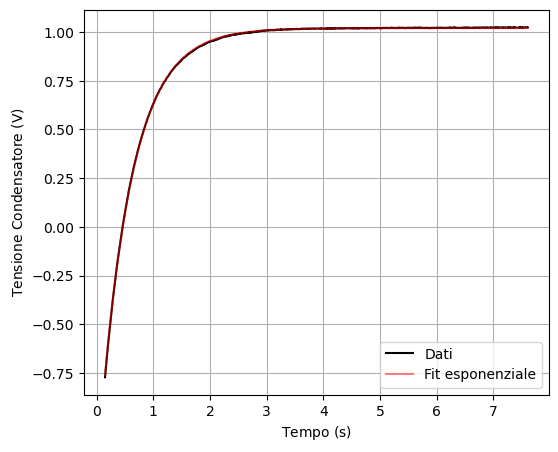

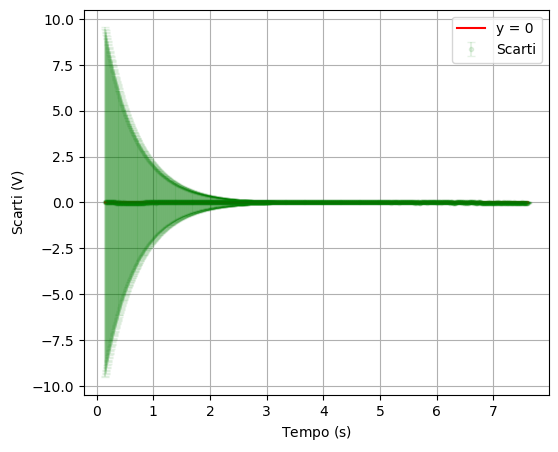

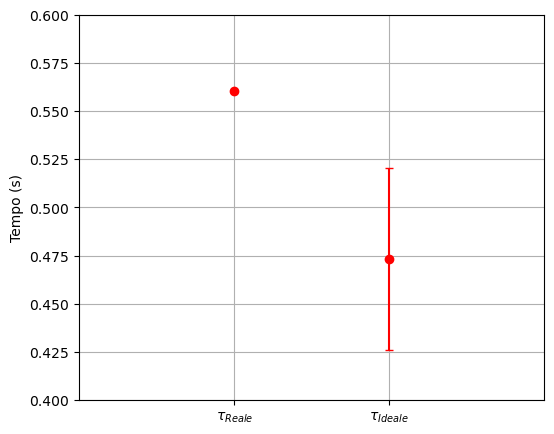

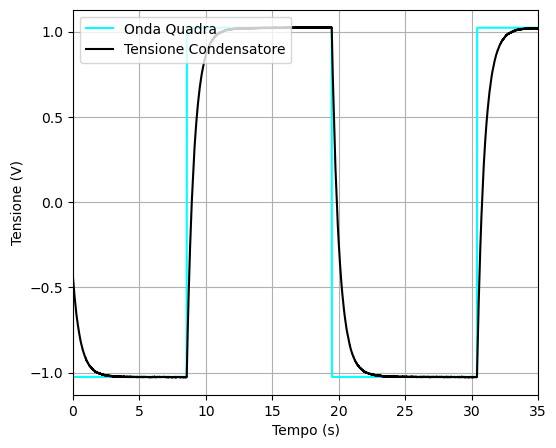

In [17]:
fig , ax = plt.subplots(figsize = (6,5))

ax.plot(delta_1, dvc_2, color = 'black', label = "Dati")
ax.plot(delta_1, y_fit, color= 'r', label= "Fit esponenziale", alpha = 0.5)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Tensione Condensatore (V)}$')
ax.grid(True)
fig.savefig("Grafico e fit(2).png", dpi = 300, bbox_inches = 'tight')
ax.legend()

fig ,ax =plt.subplots(figsize = (6,5))

ax.errorbar(delta_1, sigma, yerr = err_y, fmt = '.' , color = 'g', label = "Scarti", capsize = 3, alpha = 0.1)
ax.plot(delta_1, y_0, color = 'r', label = "y = 0")
#plt.ylim(-0.01,0.02)
#plt.xlim(0 , 0.1)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Scarti (V)}$')
ax.legend()
plt.grid(True)
fig.savefig("Grafico Scarti(2).png", dpi = 300, bbox_inches = 'tight')

fig ,ax =plt.subplots(figsize = (6,5))
ax.errorbar(index, taus, yerr = err_Taus, fmt ='o', color ='r', capsize = 3)
ax.set_xlim(-1,2)
ax.set_ylim(0.4,0.6)
ax.set_ylabel("Tempo (s)")
ax.grid(True)
fig.savefig("Confronto Tau(2).png", dpi = 300, bbox_inches = 'tight' )

fig ,ax =plt.subplots(figsize = (6,5))
ax.plot(t_1, Vg_1, color = '#00ffff', label = "Onda Quadra")
ax.plot(t_1, Vc_1, color = 'black', label = "Tensione Condensatore")
ax.set_xlim(0,35)
#ax.set_ylim(-1.4,1.4)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Tensione (V)")
ax.grid(True)
ax.legend(loc = 'upper left')
#ax.legend()
fig.savefig("Grafico Carica e scarica Condesatore(2).png", dpi = 300, bbox_inches = 'tight' )


# Circuito RC con R pari a 1397 Ohm e C pari a 2.2 e-3 F

In [18]:
file_name = "Dente 3 R1397.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

In [19]:
tau_i = C_1 * R_3

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_3 = Errore_R(R_3)
Err_C_1 = Errore_C(C_1)
inc_R_3 = Err_R_3/R_3
inc_C_1 = Err_C_1/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C_1, inc_R_3)


i = 13335
k = 17000


dt_3 = t_2[i :k:1]
dvc_3 = Vc_2[i:k:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[i]

popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt
print(f"\nTau Ideale: {tau_i} +/- {Err_Tau_i}")
Disc_Tau = pcov[1,1]
Err_Tau_r = np.sqrt(Disc_Tau)
print(f"Tau Reale: {Tau_fit} +/- {Err_Tau_r}")

y_fit = Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)
y_dati = dvc_3

sigma_x = 0.005**2
sigma = (y_fit - y_dati) 
err_y = np.sqrt(De_Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)**2 + sigma_x) * 3
y_0 = np.zeros(len(delta_3))

taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
err_A = np.sqrt(pcov[0,0])
index = [r'$\tau_{Reale}$',r'$\tau_{Ideale}$']
#print(f"Ampiezza: {A_fit} +/- {err_A} ")

Tau_Reale.append(Tau_fit)
Err_Tau_Ideale.append(Err_Tau_i)
Err_Tau_Reale.append(Err_Tau_r)


Tau Ideale: 3.0734000000000004 +/- 0.3073972050718907
Tau Reale: 3.6246997769721503 +/- 0.0002798982834325516


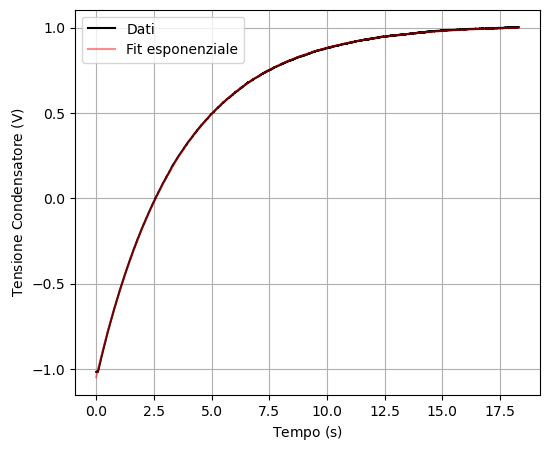

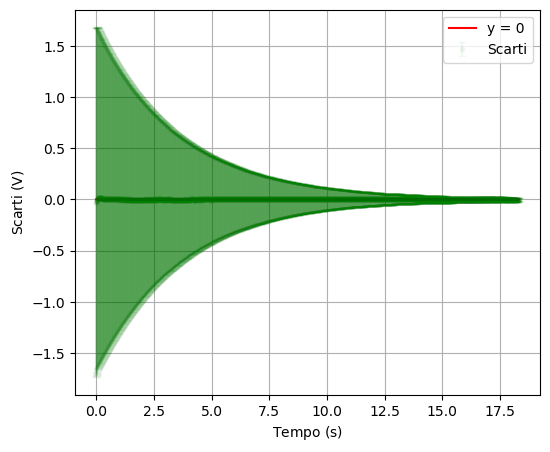

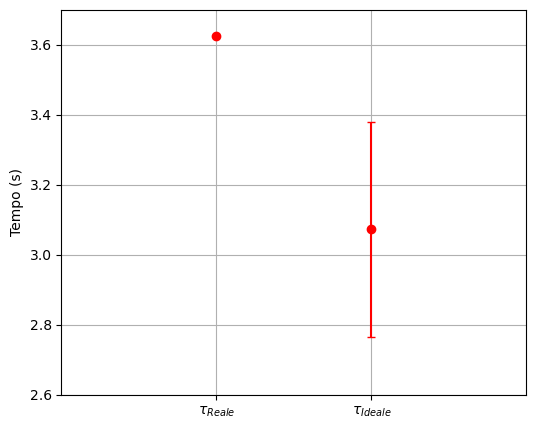

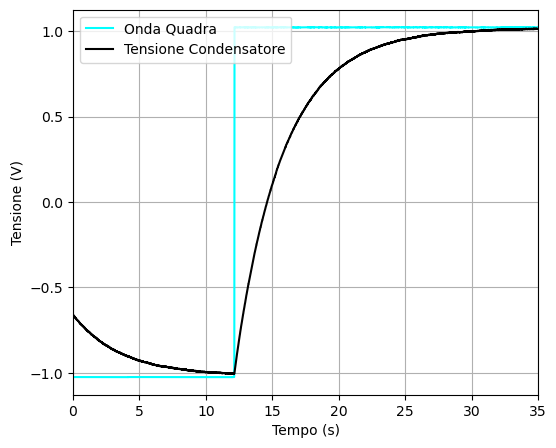

In [20]:
fig , ax = plt.subplots(figsize = (6,5))

ax.plot(delta_3, dvc_3, color = '#000000', label = "Dati")
ax.plot(delta_3, y_fit, color= 'r', label= "Fit esponenziale", alpha = 0.45)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Tensione Condensatore (V)}$')
ax.grid(True)
fig.savefig("Grafico e fit(3).png", dpi = 300, bbox_inches = 'tight')
ax.legend()

fig ,ax =plt.subplots(figsize = (6,5))

ax.errorbar(delta_3, sigma, yerr = err_y, fmt = '.' , color = 'g', label = "Scarti", capsize = 3, alpha = 0.05)
ax.plot(delta_3, y_0, color = 'r', label = "y = 0")
#plt.ylim(-0.01,0.02)
#plt.xlim(0 , 0.1)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Scarti (V)}$')
ax.legend()
plt.grid(True)
fig.savefig("Grafico Scarti(3).png", dpi = 300, bbox_inches = 'tight')

fig ,ax =plt.subplots(figsize = (6,5))
ax.errorbar(index, taus, yerr = err_Taus, fmt ='o', color ='r', capsize = 3)
ax.set_xlim(-1,2)
ax.set_ylim(2.6,3.7)
ax.set_ylabel("Tempo (s)")
ax.grid(True)
fig.savefig("Confronto Tau(3).png", dpi = 300, bbox_inches = 'tight' )

fig ,ax =plt.subplots(figsize = (6,5))
ax.plot(t_2, Vg_2, color = '#00ffff', label = "Onda Quadra")
ax.plot(t_2, Vc_2, color = 'black', label = "Tensione Condensatore")
ax.set_xlim(0,35)
#ax.set_ylim(-1.4,1.4)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Tensione (V)")
ax.grid(True)
ax.legend(loc = 'upper left')
#ax.legend()
fig.savefig("Grafico Carica e scarica Condesatore(3).png", dpi = 300, bbox_inches = 'tight' )

# Circuito RC Con Resistenza R215 Ohm e C pari a 1000 miF

In [21]:
file_name = "Dente 1 C1000 miF.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

In [22]:

tau_i = C_2 * R_2 

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_2 = Errore_R(R_2)
Err_C_2 = Errore_C(C_2)
inc_R_2 = Err_R_2/R_2
inc_C_2 = Err_C_2/C_2
Err_Tau_i = Errore_tau(tau_i, inc_C_2, inc_R_2)

i = 9
k = 1


dt_3 = t_2[Mins[i] + 20:Maxs[k]:1]
dvc_3 = Vc_2[Mins[i] + 20:Maxs[k]:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[i]

popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt
print(f"\nTau Ideale: {tau_i} +/- {Err_Tau_i}")
Disc_Tau = pcov[1,1]
Err_Tau_r = np.sqrt(Disc_Tau) * 3
print(f"Tau Reale: {Tau_fit} +/- {Err_Tau_r}")

taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
index = [r'$\tau_{Reale}$',r'$\tau_{Ideale}$']

y_fit = Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)
y_dati = dvc_3

sigma_x = 0.005**2
sigma = (y_fit - y_dati) 
err_y = np.sqrt(De_Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)**2 + sigma_x) * 3
y_0 = np.zeros(len(delta_3))

Tau_Reale.append(Tau_fit)
Err_Tau_Ideale.append(Err_Tau_i)
Err_Tau_Reale.append(Err_Tau_r)


Tau Ideale: 0.215 +/- 0.021519781742619978
Tau Reale: 0.29728232386268094 +/- 0.00018202910800204584


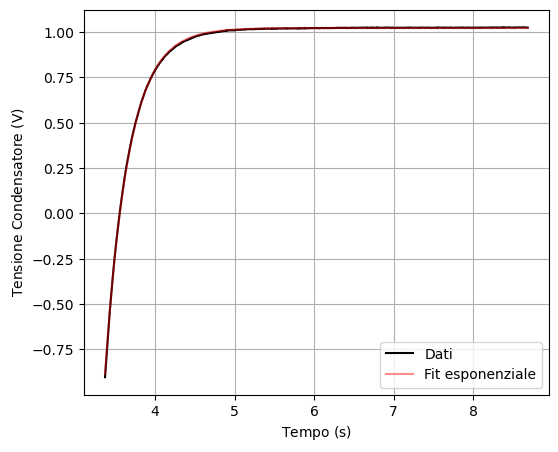

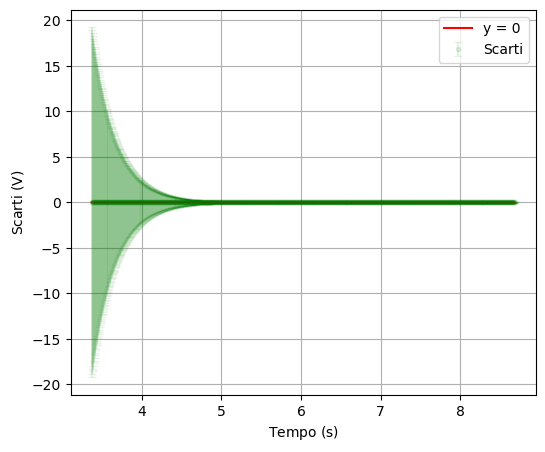

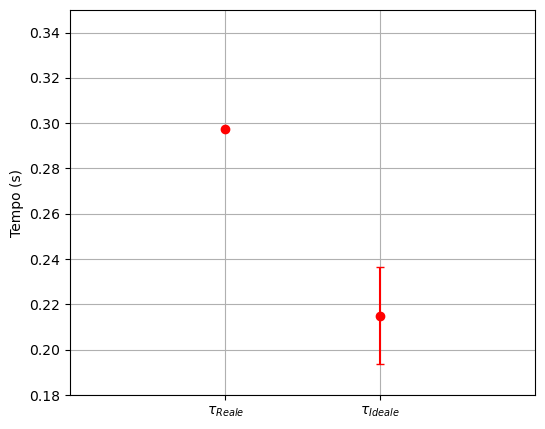

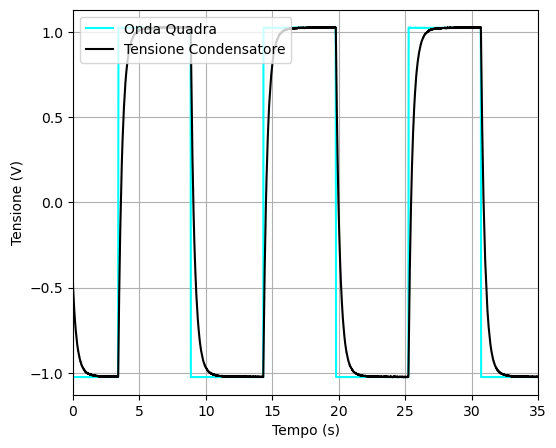

In [23]:
fig , ax = plt.subplots(figsize = (6,5))

ax.plot(delta_3, dvc_3, color = 'black', label = "Dati")
ax.plot(delta_3, y_fit, color= 'r', label= "Fit esponenziale", alpha = 0.45)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Tensione Condensatore (V)}$')
ax.grid(True)
fig.savefig("Grafico e fit(4).png", dpi = 300, bbox_inches = 'tight')
ax.legend()

fig ,ax =plt.subplots(figsize = (6,5))

ax.errorbar(delta_3, sigma, yerr = err_y, fmt = '.' , color = 'g', label = "Scarti", capsize = 3, alpha = 0.1)
ax.plot(delta_3, y_0, color = 'r', label = "y = 0")
#plt.ylim(-0.01,0.02)
#plt.xlim(0 , 0.1)
ax.legend()
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Scarti (V)}$')
plt.grid(True)
fig.savefig("Grafico Scarti(4).png", dpi = 300, bbox_inches = 'tight')

fig ,ax =plt.subplots(figsize = (6,5))
ax.errorbar(index, taus, yerr = err_Taus, fmt ='o', color ='r', capsize = 3)
ax.set_xlim(-1,2)
ax.set_ylim(0.18,0.35)
ax.set_ylabel("Tempo (s)")
ax.grid(True)
fig.savefig("Confronto Tau(4).png", dpi = 300, bbox_inches = 'tight' )

fig ,ax =plt.subplots(figsize = (6,5))
ax.plot(t_2, Vg_2, color = '#00ffff', label = "Onda Quadra")
ax.plot(t_2, Vc_2, color = 'black', label = "Tensione Condensatore")
ax.set_xlim(0,35)
#ax.set_ylim(-1.4,1.4)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Tensione (V)")
ax.grid(True)
ax.legend(loc = 'upper left')
#ax.legend()
fig.savefig("Grafico Carica e scarica Condesatore(4).png", dpi = 300, bbox_inches = 'tight' )

# Circuito RC Con Resistenza R215 Ohm e C pari a 470 miF

In [24]:
file_name = "Dente 2 C470 miF.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

tau_i = C_3 * R_2 

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_2 = Errore_R(R_2)
Err_C_3 = Errore_C(C_3)
inc_R_2 = Err_R_2/R_2
inc_C_3 = Err_C_3/C_3
Err_Tau_i = Errore_tau(tau_i, inc_C_3, inc_R_2)

i = len(Mins) - 1
k = len(Maxs) - 1


dt_3 = t_2[Mins[i] + 10:Maxs[k]:1]
dvc_3 = Vc_2[Mins[i]+ 10:Maxs[k]:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[Mins[i]]

popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt
print(f"\nTau Ideale: {tau_i} +/- {Err_Tau_i}")
Disc_Tau = pcov[1,1]
Err_Tau_r = np.sqrt(Disc_Tau) * 3
print(f"Tau Reale: {Tau_fit} +/- {Err_Tau_r}")



y_fit = Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)
y_dati = dvc_3

sigma_x = 0.005**2
sigma = (y_fit - y_dati) 
err_y = np.sqrt(De_Tau_with_c(delta_3, A_fit, Tau_fit, C_fit)**2 + sigma_x) * 3
y_0 = np.zeros(len(delta_3))



taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
index = ["Tau_R","Tau_I"]

Tau_Reale.append(Tau_fit)
Err_Tau_Ideale.append(Err_Tau_i)
Err_Tau_Reale.append(Err_Tau_r)


Tau Ideale: 0.10105 +/- 0.010114297419031389
Tau Reale: 0.12454138397468141 +/- 0.00011949165740218507


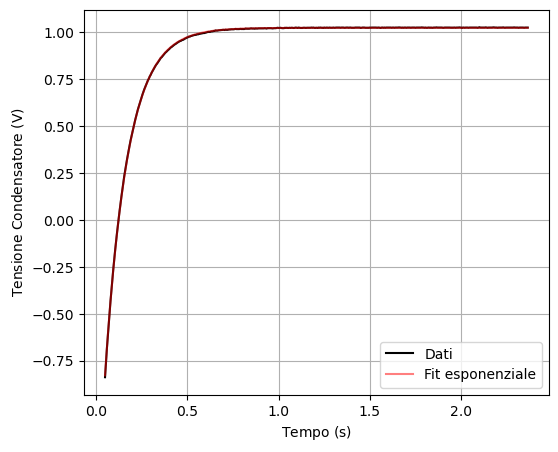

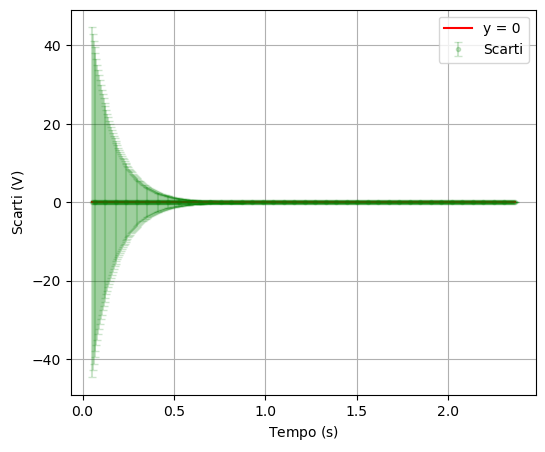

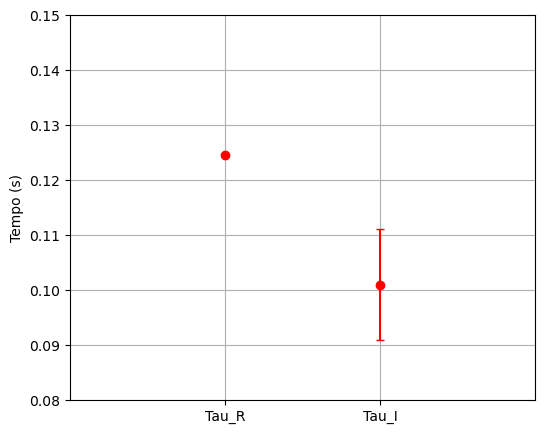

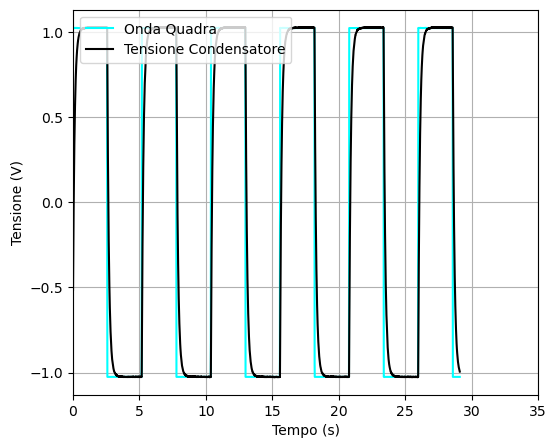

In [25]:
fig , ax = plt.subplots(figsize = (6,5))

ax.plot(delta_3, dvc_3, color = 'black', label = "Dati")
ax.plot(delta_3, y_fit, color= 'r', label= "Fit esponenziale", alpha = 0.5)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Tensione Condensatore (V)}$')
ax.grid(True)
fig.savefig("Grafico e fit(5).png", dpi = 300, bbox_inches = 'tight')
ax.legend()

fig ,ax =plt.subplots(figsize = (6,5))

ax.errorbar(delta_3, sigma, yerr = err_y, fmt = '.' , color = 'g', label = "Scarti", capsize = 3, alpha = 0.2)
ax.plot(delta_3, y_0, color = 'r', label = "y = 0")
#plt.ylim(-0.01,0.02)
#plt.xlim(0 , 0.1)
ax.set_xlabel(r'$\text{Tempo (s)}$')
ax.set_ylabel(r'$\text{Scarti (V)}$')
ax.legend()
plt.grid(True)
fig.savefig("Grafico Scarti(5).png", dpi = 300, bbox_inches = 'tight')

fig ,ax =plt.subplots(figsize = (6,5))
ax.errorbar(index, taus, yerr = err_Taus, fmt ='o', color ='r', capsize = 3)
ax.set_xlim(-1,2)
ax.set_ylim(0.08,0.15)
ax.set_ylabel("Tempo (s)")
ax.grid(True)
fig.savefig("Confronto Tau(5).png", dpi = 300, bbox_inches = 'tight' )

fig ,ax =plt.subplots(figsize = (6,5))
ax.plot(t_2, Vg_2, color = '#00ffff', label = "Onda Quadra")
ax.plot(t_2, Vc_2, color = 'black', label = "Tensione Condensatore")
ax.set_xlim(0,35)
#ax.set_ylim(-1.4,1.4)
ax.set_xlabel("Tempo (s)")
ax.set_ylabel("Tensione (V)")
ax.grid(True)
ax.legend(loc = 'upper left')
#ax.legend()
fig.savefig("Grafico Carica e scarica Condesatore(5).png", dpi = 300, bbox_inches = 'tight' )

# Funzione Av al variare della frequenza wo pari a 0.5 hz

In [26]:
ys = []

file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "0.5"
Col_1 = f"Time " + Frequenza
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

times = []
Voltages_C = []
Voltages_Generatore = []

times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [27]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_0_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_0_5)
Err_Av = np.std(Av_0_5,ddof = 1)/np.sqrt(len(Av_0_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests = []
Av_Bests.append(Av_best)

Errs_Av = []
Errs_Av.append(Err_Av)

Av best: 0.9320081221152542 +/- 0.0005460552104890498


# Funzione Av al variare della frequenza wo pari a 1 hz

In [28]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "1.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [29]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_1 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_1)
Err_Av = np.std(Av_1,ddof = 1)/np.sqrt(len(Av_1) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.7887527413490305 +/- 0.0004845858797728772


# Funzione Av al variare della frequenza wo pari a 1.5 hz

In [30]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "1.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [31]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_1_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_1_5)
Err_Av = np.std(Av_1_5,ddof = 1)/np.sqrt(len(Av_1_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)


Av best: 0.6537800079018083 +/- 0.00027196812896558196


# Funzione Av al variare della frequenza wo pari a 2 hz

In [32]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "2.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [33]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_2 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_2)
Err_Av = np.std(Av_2,ddof = 1)/np.sqrt(len(Av_2) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.544116899633833 +/- 0.0002742968778621037


# Funzione Av al variare della frequenza wo pari a 2.5 hz

In [34]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "2.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [35]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_2_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_2_5)
Err_Av = np.std(Av_2_5,ddof = 1)/np.sqrt(len(Av_2_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.46130978922079924 +/- 0.00017567637596199286


# Funzione Av al variare della frequenza wo pari a 3 hz

In [36]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "3.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [37]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_3 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_3)
Err_Av = np.std(Av_3,ddof = 1)/np.sqrt(len(Av_3) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.3986919056405766 +/- 0.00019612689321432458


# Funzione Av al variare della frequenza wo pari a 3.5 hz

In [38]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "3.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [39]:
PPeaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[0:len(Vc_Peaks):1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_3_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_3_5)
Err_Av = np.std(Av_3_5,ddof = 1)/np.sqrt(len(Av_3_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.3688225363919167 +/- 0.0019921956729109635


# Funzione Av al variare della frequenza wo pari a 4hz

In [40]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "4.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [41]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_4 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_4)
Err_Av = np.std(Av_4,ddof = 1)/np.sqrt(len(Av_4) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.3113469762310972 +/- 0.00010803507153344925


# Funzione Av al variare della frequenza wo pari a 4.5 hz

In [42]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "4.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [43]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_4_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_4_5)
Err_Av = np.std(Av_4_5,ddof = 1)/np.sqrt(len(Av_4_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.27917605754329916 +/- 0.00010857278546889247


# Funzione Av al variare della frequenza wo pari a 5 hz

In [44]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "5.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [45]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_5)
Err_Av = np.std(Av_5,ddof = 1)/np.sqrt(len(Av_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.2537659465606122 +/- 0.0001572371326519117


# Funzione Av al variare della frequenza wo pari a 5.5 hz

In [46]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "5.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [47]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_5_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_5_5)
Err_Av = np.std(Av_5_5,ddof = 1)/np.sqrt(len(Av_5_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.23219041736348695 +/- 0.00014363073431617268


# Funzione Av al variare della frequenza wo pari a 6 hz

In [48]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "6.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [49]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_6 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_6)
Err_Av = np.std(Av_6,ddof = 1)/np.sqrt(len(Av_6) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.2147373892687293 +/- 8.428881173238105e-05


# Funzione Av al variare della frequenza wo pari a 6.5hz

In [50]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "6.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [51]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_6_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_6_5)
Err_Av = np.std(Av_6_5,ddof = 1)/np.sqrt(len(Av_6_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.19916482344160488 +/- 6.85937183401107e-05


# Funzione Av al variare della frequenza wo pari a 7hz

In [52]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "7.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [53]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_7 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_7)
Err_Av = np.std(Av_7,ddof = 1)/np.sqrt(len(Av_7) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1857241300810514 +/- 0.00016821059445573268


# Funzione Av al variare della frequenza wo pari a 7.5hz

In [54]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "7.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [55]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_7_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_7_5)
Err_Av = np.std(Av_7_5,ddof = 1)/np.sqrt(len(Av_7_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.17280102338451211 +/- 8.767515927169233e-05


# Funzione Av al variare della frequenza wo pari a 8hz

In [56]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "8.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [57]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_8 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_8)
Err_Av = np.std(Av_8,ddof = 1)/np.sqrt(len(Av_8) -  1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1617469447249509 +/- 5.687336098891745e-05


# Funzione Av al variare della frequenza wo pari a 8.5hz

In [58]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "8.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [59]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_8_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_8_5)
Err_Av = np.std(Av_8_5,ddof = 1)/np.sqrt(len(Av_8_5) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1521793779881845 +/- 5.717571314563045e-05


# Funzione Av al variare della frequenza wo pari a 9hz

In [60]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "9.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [61]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_9 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_9)
Err_Av = np.std(Av_9,ddof = 1)/np.sqrt(len(Av_9) - 1)

print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.14409464407609174 +/- 8.066357223075923e-05


# Funzione Av al variare della frequenza wo pari a 9.5hz

In [62]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "9.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [63]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_9_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_9_5)
Err_Av = np.std(Av_9_5,ddof = 1)/np.sqrt(len(Av_9_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1375281851694379 +/- 9.217748821675227e-05


# Funzione Av al variare della frequenza wo pari a 10hz

In [64]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "10.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [65]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_10 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_10)
Err_Av = np.std(Av_10 ,ddof = 1)/np.sqrt(len(Av_10) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1309836020173306 +/- 0.00010581049453004219


# Funzione Av al variare della frequenza wo pari a 10.5hz

In [66]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "10.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [67]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_10_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_10_5)
Err_Av = np.std(Av_10_5 ,ddof = 1)/np.sqrt(len(Av_10_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.12444400124279631 +/- 0.00011217706741315327


# Funzione Av al variare della frequenza wo pari a 11hz

In [68]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "11.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [69]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_11 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_11)
Err_Av = np.std(Av_11 ,ddof = 1)/np.sqrt(len(Av_11) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.11821530601618382 +/- 0.00010836163521411404


# Funzione Av al variare della frequenza wo pari a 11.5hz

In [70]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "11.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [71]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_11_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_11_5)
Err_Av = np.std(Av_11_5 ,ddof = 1)/np.sqrt(len(Av_11_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.11287560766982566 +/- 8.34162517842741e-05


# Funzione Av al variare della frequenza wo pari a 12hz

In [72]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "12.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [73]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_12 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_12)
Err_Av = np.std(Av_12 ,ddof = 1)/np.sqrt(len(Av_12) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.10833030539535442 +/- 0.00010503942661341012


# Funzione Av al variare della frequenza wo pari a 12.5hz

In [74]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "12.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [75]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_12_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_12_5)
Err_Av = np.std(Av_12_5 ,ddof = 1)/np.sqrt(len(Av_12_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.10448820406872006 +/- 0.0001120466350846977


# Funzione Av al variare della frequenza wo pari a 13hz

In [76]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "13.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [77]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_13 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_13)
Err_Av = np.std(Av_13 ,ddof = 1)/np.sqrt(len(Av_13) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.1011338222630861 +/- 0.00010267330978821416


# Funzione Av al variare della frequenza wo pari a 13.5hz

In [78]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "13.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [79]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_13_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_13_5)
Err_Av = np.std(Av_13_5 ,ddof = 1)/np.sqrt(len(Av_13_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.0975424658078117 +/- 7.197003836180488e-05


# Funzione Av al variare della frequenza wo pari a 14hz

In [80]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "14.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [81]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_14 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_14)
Err_Av = np.std(Av_14 ,ddof = 1)/np.sqrt(len(Av_14) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.09410143758534718 +/- 5.7301393053612125e-05


# Funzione Av al variare della frequenza wo pari a 14.5hz

In [82]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "14.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [83]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_14_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_14_5)
Err_Av = np.std(Av_14_5 ,ddof = 1)/np.sqrt(len(Av_14_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.09055719068220149 +/- 4.5506062698614815e-05


# Funzione Av al variare della frequenza wo pari a 15hz

In [84]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "15.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [85]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_15 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_15)
Err_Av = np.std(Av_15 ,ddof = 1)/np.sqrt(len(Av_15) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.08766187945863652 +/- 4.8232817387162345e-05


# Funzione Av al variare della frequenza wo pari a 15.5hz

In [86]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "15.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [87]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_15_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_15_5)
Err_Av = np.std(Av_15_5 ,ddof = 1)/np.sqrt(len(Av_15_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.084779953562339 +/- 5.669897511213082e-05


# Funzione Av al variare della frequenza wo pari a 16hz

In [88]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "16.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [89]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_16 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_16)
Err_Av = np.std(Av_16 ,ddof = 1)/np.sqrt(len(Av_16) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.08200702083683989 +/- 6.636028289996923e-05


# Funzione Av al variare della frequenza wo pari a 16.5hz

In [90]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "16.5"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [91]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

#Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_16_5 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_16_5)
Err_Av = np.std(Av_16_5 ,ddof = 1)/np.sqrt(len(Av_16_5) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)

Av best: 0.07971972462049612 +/- 5.219178100049234e-05


# Funzione Av al variare della frequenza wo pari a 17hz

In [92]:
file_name = "Frequenze.xlsx"

df = pd.read_excel(file_name)
#print(df)
Frequenza = "17.0"
Col_1 = f"Time {Frequenza}"
Col_2 = f"Vc {Frequenza}hz"
Col_3 = f"Vg {Frequenza}hz"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()


times.append(t_2)
Voltages_C.append(Vc_2)
Voltages_Generatore.append(Vg_2)

y_sqrt_2 = []
#del(y_sqrt_2)
for i in range(len(Vc_2)):
    y_sqrt_2.append(np.sqrt(1/2))

y_2 = np.array(y_sqrt_2)
ys.append(y_2)

In [93]:
Peaks_Vc = trova_massimi(t_2, Vc_2, 0.01)
Throughts_Vc = trova_minimi(t_2, Vc_2, 0.01)

Peaks_Vg = trova_massimi(t_2, Vg_2, 0.01)
Throughts_Vg = trova_minimi(t_2, Vg_2, 0.01)


Vg_Peaks = Peaks_Vg[1]
Vc_Peaks = Peaks_Vc[1]

#Vc_Peaks = Vc_Peaks[:-1]
#Vg_Peaks = Vg_Peaks[:-1]

Vg_Throughts = Throughts_Vg[1]
Vc_Throughts = Throughts_Vc[1]

Vg_Throughts = Vg_Throughts[:-1]
#Vc_Throughts = Vc_Throughts[:-1]

Peaks_Av = np.abs(Vc_Peaks/Vg_Peaks)
Throughts_Av = np.abs(Vc_Throughts/Vg_Throughts)

Av_17 = np.concatenate((Peaks_Av, Throughts_Av))
Av_best = np.mean(Av_17)
Err_Av = np.std(Av_17 ,ddof = 1)/np.sqrt(len(Av_17) - 1)
print(f"Av best: {Av_best} +/- {Err_Av}")
Av_Bests.append(Av_best)
Errs_Av.append(Err_Av)


Av best: 0.07760891035556007 +/- 7.263039277906063e-05


In [94]:
colors = ['00', 'ff', '80', '08', 'f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80', '08', 'f0', '8f', '00', 'ff', '80', '08', 'f0', '8f','00', 'ff', '80', '08', 'f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80', '08', 'f0', '8f', '00', 'ff', '80', '08', 'f0', '8f','f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80','f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80','f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80','f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80','f0', '8f', 'cc' , 'cc', '34', '00', 'ff', '80', '80', '08', 'f0', '8f', '00', 'ff', '80', '08', 'f0', '8f','00', '80', '08', 'f0', '8f', '00', 'ff', '80', '08', 'f0', '8f','00',   ]

print(len(colors))

104


# Grafici Voltaggio/Tempo

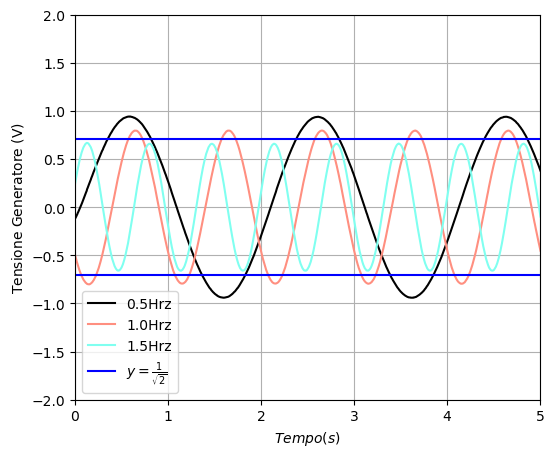

In [95]:
fig, ax = plt.subplots(figsize =(6,5))

for i in range(0,len(times)-31):

            
        ax.plot(times[i], Voltages_C [i], color = f"#{colors[i]}"+f"{colors[5*i]}" + f"{colors[2 * i]}", label = f"{i/2 + 0.5}Hrz" )

ax.plot(times[0], ys[0], color = 'b', label = r'$y = \frac{1}{\sqrt{2}}$')
ax.plot(times[0], -ys[0], color = 'b')    
ax.set_xlabel(r'$Tempo (s)$')
ax.set_ylabel(r'$\text{Tensione Generatore (V)}$')
ax.set_xlim(0,5)
ax.set_ylim(-2,2)

ax.legend()
ax.grid(True)

fig.savefig("Funzione di Trasferimento al variare di Omega.png", dpi = 300, bbox_inches = 'tight')

# Grafico Av al variare di Wo:

In [96]:
Av_best = np.array(Av_Bests)
Err_Av = np.array(Errs_Av)

#print(Av_best)
w = []
for i in range(1,35):
    w.append(i/2)


wo = np.array(w)
#print(wo)

# Stima di Cof Reale

In [97]:
tau_i = R_2 * C_3
Pi = np.pi
w0_i = 1/(tau_i * 2*Pi)

print(tau_i)
print(w0_i)

Err_w_0 = Errore_W_0(tau_i,Err_Tau_i)
inc_w_0 = Err_w_0/w0_i

popt, pcov = curve_fit(Cof_R, wo, Av_best, p0 = [w0_i ,0],sigma = Err_Av, absolute_sigma = True)
w0_fit, C_fit = popt

print(w0_fit)

#w0_fit = 1/(2*np.pi * tau_fit)
Disc_wo = pcov[0,0]
Err_wo_r = np.sqrt(Disc_wo)*3

print(f"La Cut-off Frequency Ideale: {w0_i} +/- {Err_w_0}\nLa Cut-off Frequency Reale: {w0_fit} +/- {Err_wo_r}")
w0s = w0_i, w0_fit
Err_w0s = Err_w_0, Err_wo_r
index = [r'$\omega_{Cof_{Ideale}}$',r'$\omega_{Cof_{Reale}}$']
#print(C_fit)
F_w0 = Cof_R(wo , w0_fit, C_fit)
#tau_r = 1/(w0_fit * 2*Pi)
#print(tau_r)

0.10105
1.5750118069460202
1.3036853391241405
La Cut-off Frequency Ideale: 1.5750118069460202 +/- 0.15764609454664125
La Cut-off Frequency Reale: 1.3036853391241405 +/- 0.0009757259191913346


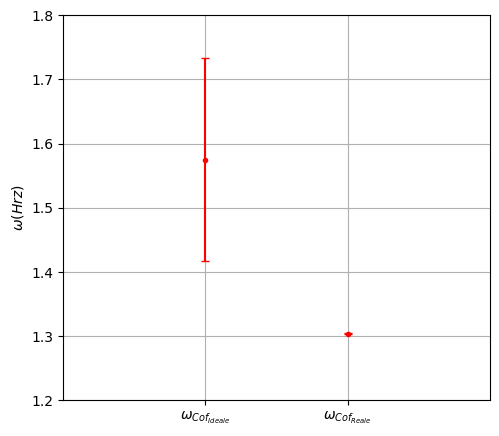

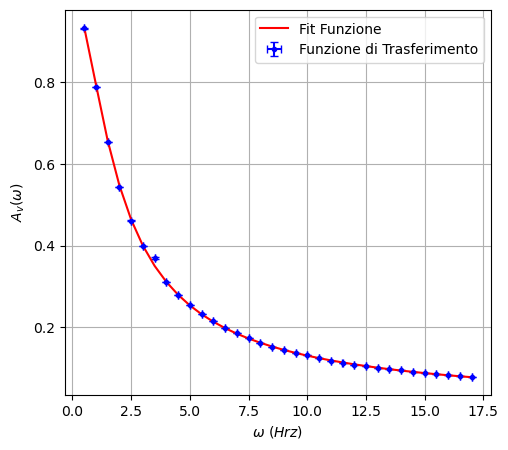

In [98]:
fig, ax = plt.subplots(figsize=(5.5,5))
ax.set_xlim(-1,2)
ax.set_ylim(1.2,1.8)
ax.errorbar(index, w0s, yerr = Err_w0s, fmt ='.', color ='r', capsize = 3)
ax.set_ylabel(r'$\omega(Hrz)$')
ax.grid(True)
fig.savefig("Confronto Omega Cof.png", dpi = 300,  bbox_inches = 'tight')

fig, ax = plt.subplots(figsize=(5.5,5))
ax.errorbar(wo, Av_best, yerr = Err_Av,xerr = 0.001, fmt ='.', color ='b', capsize = 3, label = "Funzione di Trasferimento")
ax.plot(wo, F_w0 , color = 'r', label= "Fit Funzione")
ax.grid(True)
ax.set_xlabel(r'$\omega$ $(Hrz)$')
ax.set_ylabel(r'$A_v(\omega)$')

fig.savefig("Funzione Trasferimento.png", dpi = 300,  bbox_inches = 'tight')
ax.legend()


# Valori dei dati calcolati:

In [99]:
print(f"------------------------|Resistori|------------------------\nR1: {R_1} +/- {Err_R_1:.0f}\nR2: {R_2} +/- {Err_R_2:.0f}\nR3: {R_3} +/- {Err_R_3:.0f}\n------------------------|Capacita'|------------------------\nC1: {C_1:.1e} +/- 10%  \nC2: {C_2:.1e} +/- 10%\nC3: {C_3:.1e} +/- 10%")

print("------------------------|Tau Reali|------------------------")
for i in range(len(Tau_Reale)):

    print(f"Tau Reale {i + 1}: {Tau_Reale[i]:.4f} +/- {Err_Tau_Reale[i]:.4f}\n")

print("------------------------|Tau Ideali|------------------------")

for i in range(len(Tau_Ideale)):

    print(f"Tau Ideale {i + 1}: {Tau_Ideale[i]:.2f} +/- {Err_Tau_Ideale[i]:.2f}\n")

print(f"-----------------------------------------------------------\n")
print(f"----------------------------|Av|---------------------------")
for i in range(len(Av_best)):

    print(f"{i + 1}.\t Av: {Av_best[i]:.4f} +/- {Err_Av[i]:.5f}")
print(f"\n-----------------------------------------------------------\n")


------------------------|Resistori|------------------------
R1: 573 +/- 1
R2: 215 +/- 1
R3: 1397 +/- 3
------------------------|Capacita'|------------------------
C1: 2.2e-03 +/- 10%  
C2: 1.0e-03 +/- 10%
C3: 4.7e-04 +/- 10%
------------------------|Tau Reali|------------------------
Tau Reale 1: 1.4815 +/- 0.0004

Tau Reale 2: 0.5602 +/- 0.0003

Tau Reale 3: 3.6247 +/- 0.0003

Tau Reale 4: 0.2973 +/- 0.0002

Tau Reale 5: 0.1245 +/- 0.0001

------------------------|Tau Ideali|------------------------
Tau Ideale 1: 1.26 +/- 0.13

Tau Ideale 2: 0.47 +/- 0.05

Tau Ideale 3: 3.07 +/- 0.31

Tau Ideale 4: 0.21 +/- 0.02

Tau Ideale 5: 0.10 +/- 0.01

-----------------------------------------------------------

----------------------------|Av|---------------------------
1.	 Av: 0.9320 +/- 0.00055
2.	 Av: 0.7888 +/- 0.00048
3.	 Av: 0.6538 +/- 0.00027
4.	 Av: 0.5441 +/- 0.00027
5.	 Av: 0.4613 +/- 0.00018
6.	 Av: 0.3987 +/- 0.00020
7.	 Av: 0.3688 +/- 0.00199
8.	 Av: 0.3113 +/- 0.00011
9.	 Av: 0.27

# Stessi Calcoli Visti in precedenza nei circuiti Con C fisso e R variabile e vice versa ma considerando una R parassita di C

In [100]:
file_name = "Dente%2%R573.xlsx"
df = pd.read_excel(file_name)
#print(df)
Col_1 = "Time"
Col_2 = "Vc"
Col_3 = "Vg"
t = df[Col_1].to_numpy()
Vc = df[Col_2].to_numpy()
Vg = df[Col_3].to_numpy()

R_P = []
Errore_R_P = []
#del(R_P,Errore_R_P)

In [101]:
#Calcolo Errori di C R e Tau
tau_i = R_1 * C_1
Err_R = Errore_R(R_1)
Err_C = Errore_C(C_1)
inc_R = Err_R/R_1
inc_C = Err_C/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C, inc_R)



i = 0
k = 0

Maxs, _ = find_peaks(Vc, prominence= 1)
Mins, _ = find_peaks(-Vc, prominence= 1)
dt_1 = t[Mins[i]:Maxs[k]:1]
dvc_1 = Vc[Mins[i]:Maxs[k]:1]
Error_Vg = 0.001

delta = dt_1 - t[Mins[i]]

In [102]:
popt, pcov = curve_fit(Tau_with_c, delta, dvc_1, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt


Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

Err_Tau_r =  np.sqrt(Disc_Tau)
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i


Err_Tau_r = err_Taus[0]
incertezza_Tau_r = (Err_Tau_r)/Tau_fit

R_parassita = R_parassita = np.abs(R_Parassita(Tau_fit, C_1, R_1))
Err_R_P = Errore_R_Parassita(incertezza_Tau_r, inc_C_1, Err_R_1, C_1, R_1,Tau_fit) 

R_P.append(R_parassita)
Errore_R_P.append(Err_R_P)

R_eq = (1/R_1 - 1/R_parassita)**(-1)

inc_R_P = Err_R_P/R_parassita
print(f"Incertezza di R parassita: {inc_R_P*100}%")
tau_i_p = C_1 * (R_eq)
Err_Tau_i_p = Errore_tau(tau_i_p, inc_C, inc_R_P)

print(f"La Resistenza parassita si ipotizza valga: {R_parassita} +/- {Err_R_P}")

print(f"Il tau ideale considerando la resistenza parassita vale: {tau_i_p} +/- {Err_Tau_i_p}")

#popt, pcov = curve_fit(Tau_with_c, delta, dvc_1, p0 = [1, (1/tau_i_p),-1],sigma = Error_Vg, absolute_sigma = True)

#A_fit, Tau_fit, C_fit = popt

#print(tau_i_p - Tau_fit)


Il Tau reale vale: 1.4814592085401823 +/- 0.00014901847588386544

Il Tau ideale vale: 1.2606000000000002 +/- 0.12610088611429346
Incertezza di R parassita: 3.865439480297614e-06%
La Resistenza parassita si ipotizza valga: 3843.517017489824 +/- 0.000148568824226009
Il tau ideale considerando la resistenza parassita vale: 1.4814592085401823 +/- 0.1481459208540293


# Secondo Circuito con C Costante

In [103]:
file_name = "Dente 1 R215.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_1 = df[Col_1].to_numpy()
Vc_1 = df[Col_2].to_numpy()
Vg_1 = df[Col_3].to_numpy()

In [104]:
tau_i = C_1 * R_2

Err_R_2 = Errore_R(R_2)
Err_C_1 = Errore_C(C_1)
inc_R_2 = Err_R_2/R_2
inc_C_1 = Err_C_1/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C_1, inc_R_2)


i = 44
k = 1


Maxs, _ = find_peaks(Vc_1, prominence = 1)
Mins, _ = find_peaks(-Vc_1, prominence = 1)



dt_2 = t_1[Mins[i]:Maxs[k]:1]
dvc_2 = Vc_1[Mins[i]:Maxs[k]:1]
Error_Vg = 0.001

delta_1 = dt_2 - t_1[Mins[i]]

In [105]:

popt, pcov = curve_fit(Tau_with_c, delta_1, dvc_2, p0 = [2, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt


Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

#y_fit = Tau_with_c(delta, A_fit, Tau_fit, C_fit)
#y_dati = dvc_1

#sigma_x = 0.005**2
#sigma = y_fit - y_dati
#err_y = np.sqrt(De_Tau_with_c(delta, A_fit, Tau_fit, C_fit)**2 + sigma_x)
Err_Tau_r =  np.sqrt(Disc_Tau)
#y_0 = np.zeros(len(delta))
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i
#index = ["Tau_R","Tau_I"]



Err_Tau_r = err_Taus[0]
incertezza_Tau_r = (Err_Tau_r)/Tau_fit

R_parassita = np.abs(R_Parassita(Tau_fit, C_1, R_2))
Err_R_P = Errore_R_Parassita(incertezza_Tau_r, inc_C_1, Err_R_2, C_1, R_2,Tau_fit)


R_P.append(R_parassita)
Errore_R_P.append(Err_R_P)

R_eq = (1/R_2 - 1/R_parassita)**(-1)

inc_R_P = Err_R_P/R_parassita

print(f"Incertezza di R parassita: {inc_R_P*100}%")

tau_i_p = C_1 * (R_eq)
Err_Tau_i_p = Errore_tau(tau_i_p, inc_C, inc_R_P)

print(f"La Resistenza parassita si ipotizza valga: {R_parassita} +/- {Err_R_P}")

print(f"Il tau considerando la resistenza parassita vale: {tau_i_p} +/- {Err_Tau_i_p}")

Il Tau reale vale: 0.576426608613107 +/- 7.363137365390487e-05

Il Tau ideale vale: 0.47300000000000003 +/- 0.047343519833763954
Incertezza di R parassita: 3.189493489946509e-05%
La Resistenza parassita si ipotizza valga: 1198.2576100451624 +/- 0.00038218348465179084
Il tau considerando la resistenza parassita vale: 0.576426608613107 +/- 0.057642660861603905


# Terzo Circuito RC con C fisso

In [106]:
file_name = "Dente 3 R1397.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

In [107]:
tau_i = C_1 * R_3

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_3 = Errore_R(R_3)
Err_C_1 = Errore_C(C_1)
inc_R_3 = Err_R_3/R_3
inc_C_1 = Err_C_1/C_1
Err_Tau_i = Errore_tau(tau_i, inc_C_1, inc_R_3)


i = 13335
k = 17000


dt_3 = t_2[i:k:1]
dvc_3 = Vc_2[i:k:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[i]

In [108]:

popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt


Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

Err_Tau_r =  np.sqrt(Disc_Tau)
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i


Err_Tau_r = err_Taus[0]
incertezza_Tau_r = (Err_Tau_r)/Tau_fit

R_parassita = np.abs(R_Parassita(Tau_fit, C_1, R_3))
Err_R_P = Errore_R_Parassita(incertezza_Tau_r, inc_C_1, Err_R_3, C_1, R_3,Tau_fit)

R_P.append(R_parassita)
Errore_R_P.append(Err_R_P)

R_eq = (1/R_3 - 1/R_parassita)**(-1)

inc_R_P = Err_R_P/R_parassita
print(f"Incertezza di R parassita: {inc_R_P*100}%")
tau_i_p = C_1 * (R_eq)
Err_Tau_i_p = Errore_tau(tau_i_p, inc_C, inc_R_P)

print(f"La Resistenza parassita si ipotizza valga: {R_parassita} +/- {Err_R_P}")

print(f"Il tau considerando la resistenza parassita vale: {tau_i_p} +/- {Err_Tau_i_p}")

Il Tau reale vale: 3.6246997769721503 +/- 0.0002798982834325516

Il Tau ideale vale: 3.0734000000000004 +/- 0.3073972050718907
Incertezza di R parassita: 6.609712296160521e-07%
La Resistenza parassita si ipotizza valga: 9185.031084614237 +/- 6.071041290059132e-05
Il tau considerando la resistenza parassita vale: 3.6246997769721503 +/- 0.36246997769721584


In [109]:
with open("Resistenze Parassite.txt", "w") as fp:

    for i in range(len(R_P)):
        fp.write(f"{i+1}.\t{R_P[i]:} +/- {Errore_R_P[i]:}\n")

# Primo Circuito RC con R costante

In [110]:
file_name = "Dente 1 C1000 miF.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

In [111]:
tau_i = C_2 * R_2 

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_2 = Errore_R(R_2)
Err_C_2 = Errore_C(C_2)
inc_R_2 = Err_R_2/R_2
inc_C_2 = Err_C_2/C_2
Err_Tau_i = Errore_tau(tau_i, inc_C_2, inc_R_2)

i = 9
k = 1


dt_3 = t_2[Mins[i]:Maxs[k]:1]
dvc_3 = Vc_2[Mins[i]:Maxs[k]:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[i]

In [112]:
popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt


Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

Err_Tau_r =  np.sqrt(Disc_Tau)
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i


Err_Tau_r = err_Taus[0]
incertezza_Tau_r = (Err_Tau_r)/Tau_fit

R_parassita = R_Parassita(Tau_fit, C_2, R_2)
Err_R_P = Errore_R_Parassita(incertezza_Tau_r, inc_C_2, Err_R_2, C_2, R_2, Tau_fit)

R_eq = R_2 + R_parassita

inc_R_P = Err_R_P/R_parassita
print(f"Incertezza di R parassita: {inc_R_P*100}%")
tau_i_p = C_2 * (R_eq)
Err_Tau_i_p = Errore_tau(tau_i_p, inc_C_2, inc_R_P)

print(f"La Resistenza parassita si ipotizza valga: {R_parassita} +/- {Err_R_P}")

print(f"Il tau considerando la resistenza parassita vale: {tau_i_p} +/- {Err_Tau_i_p}")

Il Tau reale vale: 0.3285746563429526 +/- 5.092369771277147e-05

Il Tau ideale vale: 0.215 +/- 0.021519781742619978
Incertezza di R parassita: -4.9035098455121044e-05%
La Resistenza parassita si ipotizza valga: -622.0010113912911 +/- 0.00030499880832756825
Il tau considerando la resistenza parassita vale: -0.4070010113912911 +/- -0.04070010113961842


# Secondo Circuito RC con R costante

In [113]:
file_name = "Dente 2 C470 miF.xlsx"

df = pd.read_excel(file_name)
#print(df)
Col_1 = "Tempi"
Col_2 = "Vc"
Col_3 = "Vg"
t_2 = df[Col_1].to_numpy()
Vc_2 = df[Col_2].to_numpy()
Vg_2 = df[Col_3].to_numpy()

In [114]:
tau_i = C_3 * R_2 

Maxs, _ = find_peaks(Vc_2, prominence = 0.01)
Mins, _ = find_peaks(-Vc_2, prominence = 0.01)

Err_R_2 = Errore_R(R_2)
Err_C_3 = Errore_C(C_3)
inc_R_2 = Err_R_2/R_2
inc_C_3 = Err_C_3/C_3
Err_Tau_i = Errore_tau(tau_i, inc_C_3, inc_R_2)

i = len(Mins) - 1
k = len(Maxs) - 1


dt_3 = t_2[Mins[i]:Maxs[k]:1]
dvc_3 = Vc_2[Mins[i]:Maxs[k]:1]
Error_Vg = 0.001

#print(f"Stampo i Massimi: {Maxs}\n E i Minimi: {Mins}")

delta_3 = dt_3 - t_2[Mins[i]]

In [115]:
popt, pcov = curve_fit(Tau_with_c, delta_3, dvc_3, p0 = [1, (1/tau_i),-1],sigma = Error_Vg, absolute_sigma = True)

A_fit, Tau_fit, C_fit = popt


Disc_Tau = pcov[1,1]
print(f"Il Tau reale vale: {Tau_fit} +/- {np.sqrt(Disc_Tau)}")
print(f"\nIl Tau ideale vale: {tau_i} +/- {Err_Tau_i}")

Err_Tau_r =  np.sqrt(Disc_Tau)
taus = Tau_fit, tau_i
err_Taus = Err_Tau_r, Err_Tau_i


Err_Tau_r = err_Taus[0]
incertezza_Tau_r = (Err_Tau_r)/Tau_fit

R_parassita = R_Parassita(Tau_fit, C_3, R_2)
Err_R_P = Errore_R_Parassita(incertezza_Tau_r, inc_C_3, Err_R_2, C_3, R_2,Tau_fit)

R_eq = R_2 + R_parassita

inc_R_P = Err_R_P/R_parassita
print(f"Incertezza di R parassita: {inc_R_P*100}%")
tau_i_p = C_3 * (R_eq)
Err_Tau_i_p = Errore_tau(tau_i_p, inc_C_3, inc_R_P)

print(f"La Resistenza parassita si ipotizza valga: {R_parassita} +/- {Err_R_P}")

print(f"Il tau considerando la resistenza parassita vale: {tau_i_p} +/- {Err_Tau_i_p}")

Il Tau reale vale: 0.14113340279229472 +/- 3.272911136955834e-05

Il Tau ideale vale: 0.10105 +/- 0.010114297419031389
Incertezza di R parassita: -4.4070090987971345e-05%
La Resistenza parassita si ipotizza valga: -757.0136137787275 +/- 0.0003336165883836152
Il tau considerando la resistenza parassita vale: -0.25474639847600195 +/- -0.02547463984784758
